In [1]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import Compose
import random


In [2]:
sample0, sr0 = librosa.load('../Dataset-for-Binary/base-audio/audio_0.wav')

In [3]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal, sr=None, color='blue'):
    plt.figure(figsize=(7,2))
    return librosa.display.waveshow(signal, sr=sr, color=color)

In [4]:
def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        disp_waveform(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        disp_waveform(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            # strokes.append(torch.tensor(keystroke)[None, :])
            # keystroke = transform(keystroke)
            strokes.append(keystroke)
            if show:
                disp_waveform(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

In [5]:
# Constants we actually need for the task
MBP_AUDIO_DIR = '../Dataset-for-Binary/base-audio/'
keys_s = '1234567890QWERTYUIOPASDFGHJKLZXCVBNM'
# keys_s = '12'
labels = list(keys_s)
keys = ['audio_' + k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [6]:
def create_dataset(n_fft, hop_length, before, after):
    for i, File in enumerate(keys):
        loc = MBP_AUDIO_DIR + File
        samples, sr = librosa.load(loc)
        prom = 0.06
        step = 0.005
        strokes = isolator(samples, sr, n_fft, hop_length, before, after, prom, False )
        print(f'File {File} length: {len(strokes)}')
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)

    return df

In [7]:
for key in keys_s:
    sample, sr = librosa.load(f'../Dataset-for-Binary/base-audio/audio_{key}.wav')
    print(len(isolator(sample, sr, 1024, 225, 2400, 12000, 0.06)), end=' ')
    

25 25 25 25 25 26 25 25 27 26 27 28 28 25 26 25 25 25 25 25 25 25 25 27 26 25 27 25 25 25 26 26 25 25 25 26 

In [8]:
n_fft = 1024
hop_length = 225
before = 2400
after = 12000
mbp_dataset = create_dataset(n_fft, hop_length, before, after)
mbp_dataset

File audio_1.wav length: 25
File audio_2.wav length: 25
File audio_3.wav length: 25
File audio_4.wav length: 25
File audio_5.wav length: 25
File audio_6.wav length: 26
File audio_7.wav length: 25
File audio_8.wav length: 25
File audio_9.wav length: 27
File audio_0.wav length: 26
File audio_Q.wav length: 27
File audio_W.wav length: 28
File audio_E.wav length: 28
File audio_R.wav length: 25
File audio_T.wav length: 26
File audio_Y.wav length: 25
File audio_U.wav length: 25
File audio_I.wav length: 25
File audio_O.wav length: 25
File audio_P.wav length: 25
File audio_A.wav length: 25
File audio_S.wav length: 25
File audio_D.wav length: 25
File audio_F.wav length: 27
File audio_G.wav length: 26
File audio_H.wav length: 25
File audio_J.wav length: 27
File audio_K.wav length: 25
File audio_L.wav length: 25
File audio_Z.wav length: 25
File audio_X.wav length: 26
File audio_C.wav length: 26
File audio_V.wav length: 25
File audio_B.wav length: 25
File audio_N.wav length: 25
File audio_M.wav len

,Key,File
0,0,"[-0.00017975706, -0.00012727422, -9.371064e-05..."
1,0,"[0.000497586, 0.00049031794, 0.0005512878, 0.0..."
2,0,"[0.0003178973, 0.00034715672, 0.0003719765, 0...."
3,0,"[0.00268178, 0.0026667328, 0.0026979204, 0.002..."
4,0,"[0.0064755157, 0.0063309446, 0.0053669587, 0.0..."
...,...,...
916,35,"[-0.250816, -0.25290224, -0.25483984, -0.25665..."
917,35,"[0.13746458, 0.13331985, 0.12892573, 0.1242144..."
918,35,"[0.0017171801, 0.0016756053, 0.0016776036, 0.0..."
919,35,"[-0.00014814909, -0.00018149172, -0.0002237720..."


In [9]:
audio_samples = mbp_dataset['File'].values.tolist()
labels = mbp_dataset['Key'].values.tolist()

audioDataset = np.array(audio_samples, dtype = object)
# labels = np.array(labels)

In [10]:
class TimeShifting():
    def __call__(self, samples):
#       samples_shape = samples.shape
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4) #Max shift (0.4)
        random_shift = random.randint(0, shift) #Random number between 0 and 0.4*len(samples)
        data_roll = np.roll(samples, random_shift)
        return data_roll

In [11]:
def time_shift(samples):
    samples = samples.flatten()
    shift = int(len(samples) * 0.4) #Max shift (0.4)
    random_shift = random.randint(0, shift) #Random number between 0 and 0.4*len(samples)
    data_roll = np.roll(samples, random_shift)
    return data_roll

In [12]:
from skimage.transform import resize


class ToMelSpectrogram:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=1024, hop_length=225)
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)
        return torch.tensor(mel_spec_resized)


class ToMelSpectrogramMfcc:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=n_fft, hop_length=hop_length)
        mel_spec = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec))
        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)
        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)

        return torch.tensor(mel_spec_resized)


In [13]:
transform = Compose([ToMelSpectrogram()])

In [14]:
audio_samples_new = audio_samples.copy()

for i, sample in enumerate(audio_samples):
    audio_samples_new.append(time_shift(sample))
    labels.append(labels[i])

# convert labels to a numpy array
labels = np.array(labels)
print(len(audio_samples_new))
print(len(labels))

1842
1842


In [15]:
audioDatasetFin = []

for i in range(len(audio_samples_new)):
    transformed_sample = transform(audio_samples_new[i])
    audioDatasetFin.append((transformed_sample, labels[i]))

In [16]:
len(audioDatasetFin)

1842

In [17]:
# Model architecture
class CNN(nn.Module):
    def __init__(self, num_classes=36):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
import time

def train(dataset, num_epochs, model_path, leave_one_out=False):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    if leave_one_out:
        train_set, val_set = dataset[:-1], [dataset[-1]]
    else:
        train_set, val_set = train_test_split(dataset, test_size=0.15)
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=16, shuffle=True)
    
    model = CNN()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.BCELoss()
    # criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0  # correct training examples
        total_train = 0 # total training examples
        tic = time.perf_counter()
        
        # print(f'---- EPOCH {epoch} ----')
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item() * inputs.size(0)

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
        toc = time.perf_counter()
        time_taken = toc - tic
        
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Evaluation of the model
        model.eval()
        total, correct = 0, 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # print("VALIDATION")
            # print(f'outputs: {outputs}')
            # print(f'predicted: {predicted}')
            # print(f'labels: {labels}')
            
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} / Val Accuracy: {val_accuracy:.4f} Iter Time: {time_taken:.2f}s")
        
        if epoch == num_epochs - 1 and epoch != 0:
            plt.plot(range(epoch+1), train_accuracies, label='Training Accuracy', color="blue")
            plt.plot(range(epoch+1), val_accuracies, label='Validation Accuracy', color="orange")
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title(f'Training vs Validation Accuracy')
            plt.legend()
            plt.show()
        
        print()
    torch.save(model.state_dict(), model_path)

torch.Size([1, 64, 64])


c:\Users\Kat\.conda\envs\tesis\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/200], Train Loss: 3.3350, Train Accuracy: 0.0744 / Val Accuracy: 0.0000 Iter Time: 1.65s

Epoch [2/200], Train Loss: 2.6126, Train Accuracy: 0.2374 / Val Accuracy: 0.0000 Iter Time: 0.93s

Epoch [3/200], Train Loss: 2.0769, Train Accuracy: 0.3471 / Val Accuracy: 1.0000 Iter Time: 0.88s

Epoch [4/200], Train Loss: 1.7058, Train Accuracy: 0.4715 / Val Accuracy: 0.0000 Iter Time: 0.86s

Epoch [5/200], Train Loss: 1.4202, Train Accuracy: 0.5562 / Val Accuracy: 0.0000 Iter Time: 0.85s

Epoch [6/200], Train Loss: 1.1712, Train Accuracy: 0.6219 / Val Accuracy: 1.0000 Iter Time: 0.86s

Epoch [7/200], Train Loss: 1.0163, Train Accuracy: 0.6746 / Val Accuracy: 0.0000 Iter Time: 0.85s

Epoch [8/200], Train Loss: 0.8838, Train Accuracy: 0.7137 / Val Accuracy: 1.0000 Iter Time: 0.86s

Epoch [9/200], Train Loss: 0.7328, Train Accuracy: 0.7719 / Val Accuracy: 1.0000 Iter Time: 0.86s

Epoch [10/200], Train Loss: 0.7029, Train Accuracy: 0.7751 / Val Accuracy: 0.0000 Iter Time: 0.86s

Epoch [11

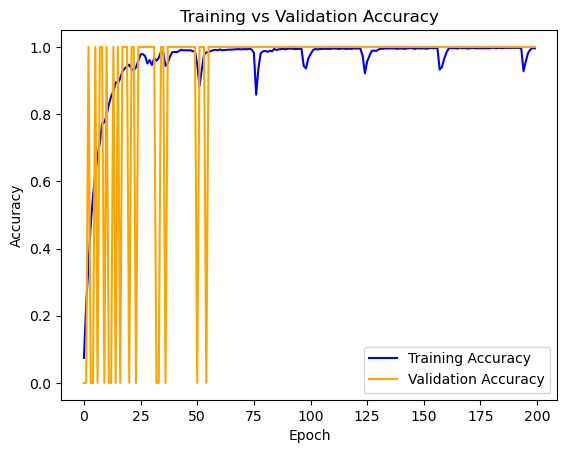

In [21]:
print(audioDatasetFin[0][0].shape)

train(audioDatasetFin, 200, "model_multiclass_cnn_12_08_24.pth", leave_one_out=True)